In [1]:
import pandas as pd
import matplotlib.pyplot as pl
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)




Using TensorFlow backend.


In [2]:
df_main=pd.read_json('train-v2.0.json')

In [3]:
df_main.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [4]:
df_main.shape

(442, 2)

In [5]:
temp=df_main['data'][0]

In [6]:
par=temp['paragraphs']

In [7]:
ques=par[0]['qas']
ques[0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

In [8]:
title=[]
questions=[]
answers=[]
answer_start=[]
is_answerable=[]

In [9]:
for sample in df_main['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])

In [10]:
len(questions),len(answers),len(answer_start),len(is_answerable)

(130319, 130319, 130319, 130319)

In [11]:
df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [12]:
df.head(10)

,Question,Answers,Answer_start,Is_answerable
0,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,In which decade did Beyonce become famous?,late 1990s,276,False
5,In what R&B group was she the lead singer?,Destiny's Child,320,False
6,What album made her a worldwide known artist?,Dangerously in Love,505,False
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False
8,When did Beyoncé rise to fame?,late 1990s,276,False
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False


In [13]:
dev_data=pd.read_json('dev-v2.0.json')

In [14]:
questions=[]
answers=[]
answer_start=[]
is_answerable=[]
for sample in dev_data['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])
dev_df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [15]:
dev_df

,Question,Answers,Answer_start,Is_answerable
0,In what country is Normandy located?,France,159,False
1,When were the Normans in Normandy?,10th and 11th centuries,94,False
2,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
3,Who was the Norse leader?,Rollo,308,False
4,What century did the Normans first gain their ...,10th century,671,False
...,...,...,...,...
11868,What is the seldom used force unit equal to on...,sthène,665,False
11869,What does not have a metric counterpart?,Null,Null,True
11870,What is the force exerted by standard gravity ...,Null,Null,True
11871,What force leads to a commonly used unit of mass?,Null,Null,True


<IPython.core.display.Javascript object>

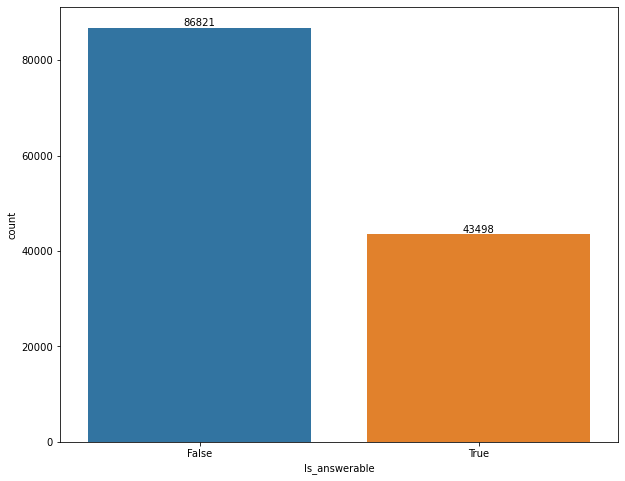

In [16]:
pl.figure(figsize=(10,8))

ax=sns.countplot(df['Is_answerable'])
rects=ax.patches

for rect in rects:
    height=rect.get_height()
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+5,s=height,ha='center',va='bottom')
pl.show()

<IPython.core.display.Javascript object>

-0.4 0.8
0.6 0.8


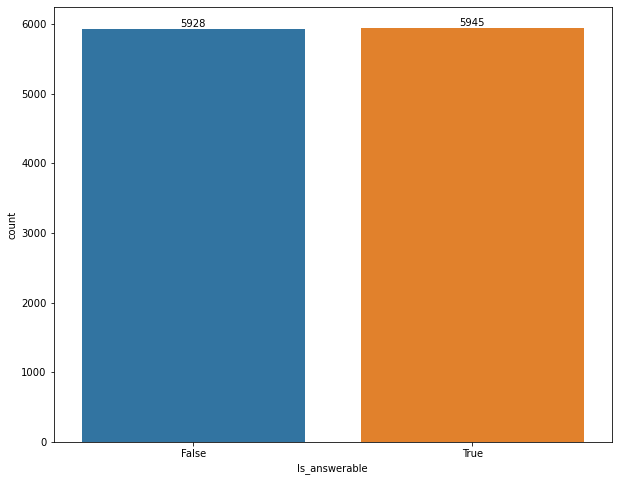

In [17]:
pl.figure(figsize=(10,8))

ax=sns.countplot(dev_df['Is_answerable'])
rects=ax.patches
for rect in rects:
    height=rect.get_height()
    print(rect.get_x(),rect.get_width())
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+1,s=height,ha='center',va='bottom')
pl.show()

In [18]:
len(df),df['Answer_start'].nunique()

(130319, 1604)

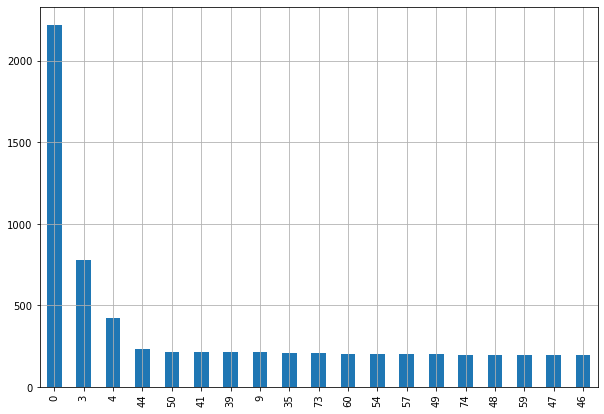

In [19]:
df['Answer_start'].value_counts()[1:20].plot(kind='bar',figsize=(10,7))
pl.grid()
pl.show()

In [20]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [21]:
df['len_que']=df['Question'].apply(lambda x: len(x))
df['len_ans']=df['Answers'].apply(lambda x: len(x))

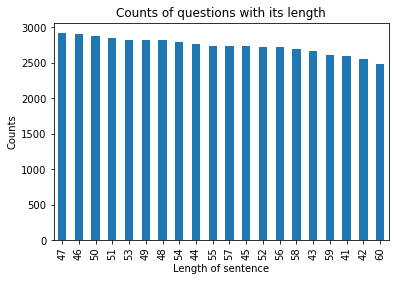

In [22]:
df['len_que'].value_counts()[:20].plot.bar()
pl.title('Counts of questions with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

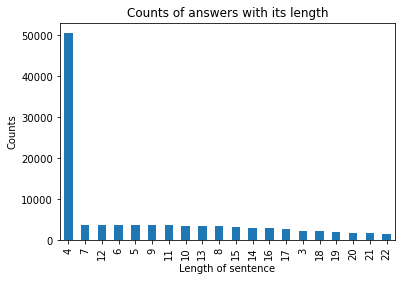

In [23]:
df['len_ans'].value_counts()[:20].plot.bar()
pl.title('Counts of answers with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

In [24]:
df.describe()

,len_que,len_ans
count,130319.000000,130319.000000
mean,58.507739,14.758884
std,73.757111,19.193666
min,1.000000,1.000000
25%,44.000000,4.000000
50%,55.000000,7.000000
75%,69.000000,17.000000
max,25651.000000,239.000000


In [25]:
df.drop(107709,axis=0,inplace=True)

In [26]:
df.reset_index(drop=True,inplace=True)

In [27]:
df.head()

,Question,Answers,Answer_start,Is_answerable,len_que,len_ans
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,40,17
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,58,19
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,64,4
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,45,14
4,In which decade did Beyonce become famous?,late 1990s,276,False,42,10


In [28]:
len(df)

130318

In [29]:
df=df.sort_values('len_que',ascending=False)[5000:].copy()

In [30]:
df_s=df.sample(10000).copy()

In [31]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [32]:
for line,t in zip(df_s['Question'],df_s['Answers']):
    input_texts.append(line)
    target_texts.append(t)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
    for char in t:
        if char not in target_characters:
            target_characters.add(char)

In [33]:
print(input_characters)

{'*', '7', ']', ' ', 'a', ';', 'm', '√', 'Ż', '0', 'Z', '–', 'E', 'á', '"', 'h', 'ó', '1', 'o', '.', '8', 'S', '⟩', '3', 'ā', 'J', 'ü', 'Y', '+', 'C', 'õ', 't', 'j', '’', ')', 'B', '6', 'r', 'c', 'ý', 'I', 'α', 'ö', '◌', '=', 'G', '?', '/', 'L', 'T', '%', 'ě', '⟨', 'V', 'w', '!', '&', '2', 'g', '(', 'Q', '5', 'P', '[', 'n', 'í', 'ã', 'O', 'y', 'N', 'é', 'z', 'A', 'f', 'H', 'X', 'à', 'ß', 'ź', 'U', 'D', 'M', 'ò', 'ὠ', 'ν', 'K', 'ć', 'k', 'e', 'ń', ':', 'd', 'p', 'κ', 'b', '$', 'ʱ', 'v', 'W', 'i', 's', 'q', 'F', '4', 'ǒ', 'x', 'š', 'ä', "'", '9', '-', ',', 'R', 'u', 'l'}


In [34]:
print(target_characters)

{'*', '7', '′', ']', 'ł', ' ', 'ǎ', 'a', 'န', ';', 'ō', '統', 'm', 'Ż', '0', '–', 'Z', 'ī', 'E', '¥', '導', 'á', 'æ', '"', 'h', 'ó', '1', 'o', '家', '.', '8', 'S', 'သ', '航', '斗', '{', 'ô', '3', '·', '—', 'ā', 'J', 'ü', 'Y', 'C', '£', 't', '“', 'j', '’', ')', 'B', '6', 'ơ', 'r', 'c', 'I', 'ö', 'G', 'ă', '/', '%', 'T', 'L', '?', 'ç', 'č', 'ś', 'ē', 'ž', '그', '北', 'V', 'w', '!', '星', '&', '武', '士', 'É', '2', 'g', '(', 'Q', '5', 'P', '[', '€', 'ˀ', 'n', 'Ś', 'ṣ', 'í', 'ã', '”', 'O', '²', '도', 'y', 'N', 'z', 'é', 'A', 'f', 'H', 'X', 'à', 'ß', 'ū', 'ḱ', 'ɕ', 'U', 'D', 'ñ', 'M', '×', 'ò', 'Γ', 'K', 'ć', 'k', 'e', 'ń', ':', 'd', 'p', '系', 'b', '리', '$', 'v', '°', 'W', 'ာ', '스', 'i', 's', 'း', 'q', '♠', 'ʼ', 'F', '4', '−', 'è', '∖', 'Á', 'x', 'ố', '衛', 'ä', "'", '9', '}', '-', 'ḷ', ',', 'R', 'ú', 'đ', 'u', 'l'}


In [35]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))
num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)
max_encoder_len=max([len(txt) for txt in input_texts])
max_decoder_len=max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_len)
print('Max sequence length for outputs:', max_decoder_len)

Number of samples: 10000
Number of unique input tokens: 115
Number of unique output tokens: 162
Max sequence length for inputs: 100
Max sequence length for outputs: 152


In [36]:
input_token_index=dict([(char,i) for i,char in enumerate(input_characters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_characters)])

In [37]:
print(input_token_index)

{' ': 0, '!': 1, '"': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, 'a': 57, 'b': 58, 'c': 59, 'd': 60, 'e': 61, 'f': 62, 'g': 63, 'h': 64, 'i': 65, 'j': 66, 'k': 67, 'l': 68, 'm': 69, 'n': 70, 'o': 71, 'p': 72, 'q': 73, 'r': 74, 's': 75, 't': 76, 'u': 77, 'v': 78, 'w': 79, 'x': 80, 'y': 81, 'z': 82, 'ß': 83, 'à': 84, 'á': 85, 'ã': 86, 'ä': 87, 'é': 88, 'í': 89, 'ò': 90, 'ó': 91, 'õ': 92, 'ö': 93, 'ü': 94, 'ý': 95, 'ā': 96, 'ć': 97, 'ě': 98, 'ń': 99, 'š': 100, 'ź': 101, 'Ż': 102, 'ǒ': 103, 'ʱ': 104, 'α': 105, 'κ': 106, 'ν': 107, 'ὠ': 108, '–': 109, '’': 110,

In [38]:
print(target_token_index)

{' ': 0, '!': 1, '"': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '[': 53, ']': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '{': 81, '}': 82, '£': 83, '¥': 84, '°': 85, '²': 86, '·': 87, 'Á': 88, 'É': 89, '×': 90, 'ß': 91, 'à': 92, 'á': 93, 'ã': 94, 'ä': 95, 'æ': 96, 'ç': 97, 'è': 98, 'é': 99, 'í': 100, 'ñ': 101, 'ò': 102, 'ó': 103, 'ô': 104, 'ö': 105, 'ú': 106, 'ü': 107, 'ā': 108, 'ă': 109, 'ć': 110,

In [39]:
import numpy as np
encoder_input_data=np.zeros(
    (len(input_texts),max_encoder_len,num_encoder_tokens),
    dtype='float32'
)
decoder_input_data=np.zeros(
    (len(target_texts),max_decoder_len,num_decoder_tokens),
    dtype='float32'
)
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_len, num_decoder_tokens),
  dtype='float32')

In [40]:
encoder_input_data.shape,decoder_input_data.shape

((10000, 100, 115), (10000, 152, 162))

In [41]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    print(input_text)
    print()
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
          # decoder_target_data will be ahead by one timestep
          # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

What objects were not used by early farm societies in the Near East ?

What does knowing the sexual population influence?

What does bandes dessinées mean?

Who covers incorporated associations or councils?

Which Arsenal domestic supporters' club was the first to be created?

Who won the Battle of Lake George?

Men and women should maintain what, according to the Robbins Report?

In what year did the Teutonic Order begin to rule eastern Prussia?

Who did Harper Lee become childhood friends with?

What were cans originally believed to maintain in beer?

Along with Cornell University, what institution is involved in the building of Cornell Tech?

What transit has 19 buses?

What is the smallest police department of South Carolina?

The book debuted at number two on which best seller's list?

From what language does the word diálektos come?

When did personnel first start thinking about using lasers in combat?

How often have new buildings for housing appeared at Eton?

What percentage o


Where is a royal assent ceremony held within the United Kingdom?

In what direction does Cocol lie from St. Barts?

What kind of light do hydrogen-oxygen flames make?

Bostons businesses rank top in the country for what?

The forms of the acts included in communication depends on what?

Until what event did the ancient methods of bead spinning last?

What group is conducting exploration for Rajasthan's crude oil??

What are some flying animals that Darwin thought might have evolved from bats?

Along with criminal law, what facet of law doesn't consider evidence related to emotion?

How long did it take for Myanmar to recover from the collapse of it's first kingdom ?

Which is the other name that Madonna is always referred as?

What comes before state and territorial laws in the 50 U.S states?

By what were the later kings of the Rastrakuta Empire influenced?

When was 'The Warriors' movie released?

What is ukiyo-e not an example of?

How is most of Tucson's water used?

Who was able 

What is the world's largest cosmetic company?

Which countries did Yaroslav's sons become kings of?

In Buddhism, samatha meditation can calm the what?

Who gave cardinals the right to elect the pope under the Papal Bull In nomine Domini?

Increased use of what material marked Cubism influence in architecture?

In what year did Mount Baker receive the highest recorded snowfall?

When did Buridan state that teams of ten horses could not open a bellow with a sealed port?

Chopin wrote in 1842 that he had to lie in bed all day because what ached so much?

Which city surpassed the population of Philadelphia?

What was the mandated closing time of pubs in Kensington in the 1960s?

What is first copied into RNA as an intermediate in the manufacture of the final protein product?

When did Bronck reach the New York area?

What does the closeness to friendly troops require of these US Air Force aircraft?

Who does the President report to?

What did the Parliamentary members yell as the relay pa

How many men did the Russians lose after three hours?

Where was there a terminal priced over CNY2,000RMB?

How clear is the ability of vertebrae species to feel pain?

What group of people were the charges of genocide brought up against in April 1994?

When was the Magna Carta peace treaty agreed upon?

How long did it take for Jacobi's first world record to be broken?

Who did Victoria divorce?

Is there any structural damage associated with secretory diarrhea?

What body carried out on-site inspection of member schools of the RIBA Board?

What is one of Israel's most important culturural institutions?

Where did Churchill want the Australian divisions bound for Singapore to be diverted to?

When did Windows 8 decrease the price of Windows 8 for devices that cost less than $250?

What color was the PlayStation 3 that was included in the God of War: Ascension bundle in the UK?

How do Ismailis differ from Twelvers?

In which month in 1913 did Albert start serving on the HMS Cumberland

Where did Spielberg's paternal grandparents immigrate from?

What two countries were also involved in the Cold War?

Who has been criticized by Hawking for his stance on the Big Bang?

Voters in the city approve which kind of amendment?

What is there no official provision for?

Which abbot of St. Alban's abbey built a mechanical clock around 1330?

Plesiosaurs and Ichthyosaurs were mostly hunted by with competitive species?

Two works that had either overt moral or didactic purpose are what?

What is not a service the lab conducts?

Where did Japan open a military school in 1855?

When was Equatorial Africa established?

What is the name of the military in Burma ?

Brickman Music Group merged with SME in what year?

What did the bureau investigate before the 1940s?

On what day did the Kanye's famous George W. Bush criticism take place?

What was the station concerned about with regard to VHF transmissions?

Who are the main female role models for Scout during the story?

Who is the l


What did the first Council of Nicaea require alterations for?

What percentage of Niger receives and annual rainfall above 10mm?

Where did the strike take place?

Which service contains 10 HD channels and finished its roll out in October 2022?

What did Bell create in 1881?

Who was the architect that design the New Haven Free Public Library?

Who was Frédéric's first professional teacher in music?

Who ruled Turkey when the Armenian genocide happened?

What football league team is located in Plymouth?

What type of map originated in China?

How are people with AIDS perceived?

A possible rebuttal to Gray's argument appears in Popper's reply to which philosopher?

When is it okay for irregular players to use their hands?

In what country is Butrint?

What was unique about Einsteins invention?

What causes the Southeast Asian regions to experience wet & dry seasons?

Where do birds usually lay their eggs?

What has the life expectancy risen to since 2000?

Which endemic species has sy

What city doesn't have more Fortune 500 headquarters than Houston?

What did Eritrea do when it was accused of planting bombs at the African Union summit?

Who was a famous freedom producer?

What does copper wires along with zinc on roofs help to prevent?

What does Sure South Atlantic LTD offer?

Where was the city originally located?

What is the meaning of the term Kurdus in English?

What equestrian event has Valencia hosted?

Why will water become concave, according to the relativity theory?

What component of the Super Slim did CNET call "the hardest yet"?

What is the second most spoken language in Eritrea?

What did Paine call Reflections?

What medals did Kerry win?

Who wrote to Burke on Nov 4, 1793?

Who said that architecture was able extend beyond function?

Which languages of the 19th century evolved from Vulgar Latin?

How many sections does an insect's body appear to be divided?

Where has the NCDA National DanceSport championships been held?

How many inhabitants did 

If bob remembered how to bake a cake after seeing this on television what memory is he using?

Why did the Luftwaffe bomb the RAF Fighter Command?

Where in Central Park are performances offered at no cost?

What has the government had for 10 to 15 years?

When were the Allobrogi defeated?

Who disputed al-Haytham's definition of topos?

What organization did the church expect Montini to continue?

What must be purchased with hunting license is comes in a limited number?

Which physicist quoted the Quran in his address after receiving the Nobel Prize?

Which interstate is the only one that uses kilometer posts instead of mileposts?

How many soldiers did Lee have remaining when he surrendered?

What is rarely "ladder-like"?

Who was the author of the book, "Survivals of Roman Religion?"

When in the cycle do wake-sleep cycles break off from the circadian period?

How do animals use plants?

Who produced the contents of World Three?

Who is the most famous street artist who works with m

What is SWR?

Who made Chopin's death mask?

Who was Google's CEO in 2007?

What ship were copies of The Sun thrown from?

What isn't the purpose of charms?

What can a person wear to prevent frost on the skin?

What were crows once categorized as but are not longer considered to be?

What is Bell famous for inventing?

How is Corinthian bronze made?

When was the first lighting used on an airport?

Egypt was added to the Ottoman Empire in what year?

 A broadcasts optimum format depends on what three things?

From what building did the Queen do her television broadcast about Diana's death?

Which political group created an alliance between the Soviet and German governments?

Who was elected president of the Congo in 1992?

How many African Americans lived in Charleston in 1860?

What does a wavelet do?

What do Mexicans call Mexico City?

What sort of capacitors have traditionally been used in radio tuning circuits?

What was Locke's nationality?

Who was one of the New Testament Writ

What did students lay down?

Where did the Constitution write that it's not possible to give each department equal power?

Whose decision did the Supreme Court reject in Thailand?

What are too technical to sit well in "history of science" programs?

What French forces assisted Japan?

What is the general consensus of the axioms and inference rules declared in Principia Mathematica? 

What type of pumps are sometimes called low yield pumps?

Which document allowed for Indigenous peoples the right to Tasmania?

What is the average January low temperature in downtown San Diego?

What are East and West Estonian languages based on?

On what day did Gregory of Nazianzus call Athanasius the "Pillar of the Church"?

What is the Digital World in which the Digimon creatures live?

What does the principal officer Melinda Gates control?

What years were Oklahoma's hottest summers?

What actor was scheduled to attend a San Francisco Olympic protest?

What kind of religion is Hinduism considered?




Who was the new movement meant to suit the needs of?

Who gave instructions to ignore the school issue?

What kind of properties does Coulomb's law have?

What refers to a specific group of people who occupied the institutions of the state?

What did System R avoid to change the way data was stored?

Who does Modern Orthodoxy assign a central role to?

Who won a majority in Parliament?

Murders are what fraction of the national average in Provo?

Is TB common or uncommon in the United States?

What town is The Crow and Gate located in?

Before Islam was introduced, what was a common building material in Somalia?

What did Erich Raeder believe the Luftwaffe needed to do?

Where is the mission for the European Central Bank found?

Who gave Bern their bears?

Who supported the reaction against the government?

What is the primary sidearm used by the U.S. Army?

Who are the CAF supposed to protect?

What did the advancements during the revolution improve for people?

When did Australia se


What was Chopin's father's first name?

What had nine California participants?

What single year did Windows 95 use to apply rules to Israel's time changes?

What Estonia view itself as after winning independence?

Where was the capital relocated to during the First Sino-Japanese War?

When did the original speakers of Sanskrit migrate to the north-west?

What group murdered Uthman ibn al-Affan?

What is the UN developmental designation for Tuvalu?

Brincourt made preparations to invade which state?

What is the population density of the largest Canton of Graubunden, located in the Alps?

What year did hernando de Soto arrive in Joara?

Who first suggested the existence of discrete inheritable units?

What makes peer-to-peer networks the same as other online providers?

What did Richard Borcherd make a complete classification of?

What country has been the focus of the foundation's monitoring activities?

Who assumed ownership of the Cubs after Hulbert died?

What did samurai wives sp


When did the United States land in British hands?

How many metres apart are 181st Street's two subway stations?

What baseball team was Comcast's partner in their New York sports network?

What type of musical piece did Chopin compose for his friend's ruling father?

By the time of the French Revolution there were how many distinct Jewish populations?

What did Pope Pius V establish in 1570?

Along with quick design times, what problem does Multiwire cut down on?

Other than subordinate standards, what else do Presbyterians consider important?

What did an October 20, 1879 law state?

In the latter half of the 11th century, Rashi refers to what two things?

Do Anglo-American grand lodges accept women as members today?

What do Christians in the Eritrean lowland wear?

When did the Scholastic Magazine of Notre dame begin publishing?

In what year did Brown start offering a Master of Social Work?

What are the stems used for in cacti?

BDNF is an abbreviation for what term?

What are t

When did Scotland begin to use January 1 as the start of the new year?

During what years was Theodor Hesburgh president of Notre Dame?

How many segments make up an insects abdomen?

PeeWee the Piccolo was what?

What club did the term "Warehouse music" originate from?

What were perforated stones used for?

The removal of what animal from Yellowstonw National Park affected beaver populations?

When the Royal Assent Act 1967 is not followed, assent is considered granted when?

When did Eisenhower stop smoking completely?

Which years were the War of the Thuringian Succession fought?

How much is the Gordie Howe International Bridge expected to cost?

When was Admiral Flota Sovetskovo Soyuza Kuznetsov first launched?

In which psychoanalysts clinics did Popper volunteer?

Which contestant received a lot of attention because of his widowhood?

How many new populations were lost?

What is based on suface ice and melt conditions?

What part of your vehicle should you remember to check twi

What name did Armenia gain it's name from?

Who did Madonna's look and style of dressing influence?

How much did Barcelona pay to sign  David Villa?

What is another name for the Circuit Recardo Tormo?

At what airport was Schwarzenegger's jet forced to make an emergency landing in 2009?

What area of New Haven comprises the area centered around the business district and New Haven Green?

Where is the Cork Public Museum?

How old was Beyonce when she went to her first Michael Jackson concert as a kid?

What did Mongol rule of China remain separate from?

What is usually more similar to traditional Chinese characters?

What was the lifespan of Theodore Hesburgh?

 What language do some of the different states specify the oath of office include?

Along with German and English, what standardized West Germanic language is similar to Dutch?

What group supported roaming cannons?

What do critics of affirmative action believe should be the main factor in hiring?

What are some companies tha

Did everyone agree that Amendment 36 was a good idea?

What term has been used to refer to the people of the region since the 1200's?

What other language is often spoken in the United states?

What did French and English farmers do during the Little Ice Age to gain more solar energy?

What percentage of the population did Turkish Cypriots make up?

The officials in Mexico reduced the price of what food from six cents to two cents per pound?

What is the name of the nearest large commercial airport?

What method formally adds inverses to elements to any monoid?

When was a new sytle of carved top and back construction mandolins created?

What prevents body rupture at low altitude when human body is bloated by gas bubbles?

Around what time was the total legal number of ennoblement at 800?

How many companies did a judge say infringed on Dr. Moustakas's prior red light patent in 2015?

What language family does Old English belong to?

What is possible to run by using Boot camp, even tho

The NHL refused the CBC access to hockey games during which season?

What breed of worm is named after a town in Java?

What year was the Seven Years' War prevented?

What book details the submission of Jesus to being crucified?

What was the first alphebetization use of ASCII?

Spectre won an Academy Award in which category?

In what year did Dominic order his followers into an institutional life?

Of all of Estonian's language reformers who is the least well known?

What is the area above the treeline defined as?

In what year did Comcast Entertainment take over operation of Colorado's Emergency Alert System?

When was Easter Sunday celebrated after the equinox?

What is the most difficult connection between the Greeks of old and those of today?

What did ritual cloth in Himchali cause?

How many congressional districts were there at the peak population?

What does gas produce when burned?

The idea that people are unchanging and stay the same even through changes is considered what?

Who paid for Chopin's apartment in Chaillot?

How many students receive financial aid at Eton?

How many 60-gun frigates did the Russians lose in the Black Sea?

Who was the first multiracial president elected in the US

What commission merged the National Archives with GSA?

What is a notable company based in Plymouth?

How many Chopin polonaises were published after his death?

Who did The League of Nations grant  France mandates over?

Who created an office to study these effects?

What percentage of cloud-based instant messaging platform Telegram's users are from Iran? 

What is a recent development in sequencing methods?

What did some software do to the ASCII characters?

How many community colleges serve Houston?

Hormuud Telecom launched what service in 2012?

The Saint Helena pound is at parity with what other currency?

A plan for a semi-detached houses was dated for what year?

Which form of copper is shock sensitive?

What lakes are in the middle of Nanjing?

Where did Augu

How many people did Fitzroy have per km2 between 2012 and 2013?

Who produced 'From Mambo To Hip Hop'?

What is the name of the singer that sings songs representing the rains?

How many guns were taken from the Earl of Mornington?

With what speed does post-glacial rebound occur?

 What German war policy precipitated US involvement in WWII?

What notable defeat was suffered by the Arabs under Hisham?

Who is the race concept widely used by?

Who can serve in the Swiss military voluntarily?

What document changed the name of Russia in 1937?

How is no contest related to a draw, if at all?

What type of satellites does the American GPS system use?

What is a mammal whose genome has been sequenced?

What sort of current is induced when the capacitance of a capacitor is altered?

Slovo, slava, and slukh all originate from what Proto-Indo-European root?

Buddhist temples in which two cities made use of the shoen system?

Which Federal Records Center houses materials relevant to JFKs assassi


What kind of role do insects play in their ecosystem?

What were Kupka's two entries at the Salon d'Automne? 

Who made the first dialectal Russian dictionary?

What has been in use since 1015?

When did Stephen II become pope?

How many people does M'era Luna Festival attract?

When does Christmas music on AC format stations usually begin?

When was the General Availablity Cumulative Update provided?

which party dominates most of the rest of florida 

In what time period did the quarrel between the Ancients and the Moderns peak?

What does fruit with seeds provide to establish relationships among species?

What is the name of the Presbyterian church in Brazil with Dutch origins?

The term unaspiration sometimes refers to what?

What did the ACLU violate?

What legendary figure was featured in the Historia Regum Britanniae?

Over how many people typically attend New York's version of the Carnival?

Where was the first movie projected for a paying audience in Paris?

Where do many mod


When was the FA Premier League Agreement signed?

Who was the opponent of the Allies?

What was the gross state domestic product of Delhi for 2011-12?

Self-image, self-esteem, and individuality relate to what?

What did the Personal Use License allow?

What do the chirigotas sing about?

During which period did Sumerian cities begin using slave labor?

What is the present day system being used by Texas for representation?

What was the name of the Finnish aeroplane attacked by the Soviets?

Who is known for his statement that individuals have a right to "Life, Liberty and Property"?

What sound do users hear when uncovering weapons in the game?

How long after the Permian-Triassic extinction did animal recovery take to completion?

What were Vitruvius' three principles for a well made building?

When did the Tehcir Law come to fruition?

Where did the Padres move when the Escondido stadium fell through?

What was declared as having ceased to exist?

What are the two former Presbyteri

What are staple foods in Chinese areas?

When was Texas International Airport renamed to Hobby Airport?

Who was Paris's first head of police?

How many disabled people are registered in Tajikistan?

By reducing carbon in liquid pig iron, what was created?

Where were 400 non-lichen-forming fungi found?

The enumeration areas in Namibia do not overlap with what in order to get reliable data?

In what year did Napoleon attempt to resume peace talks?

What paved the way towards an occupation of the Umayyads by the Iberians?

What kind of endings does the conditional mood add for each category in English?

Who ruled against neutrality in February 2015?

What is the most notable SAM that can detect a stealth target?

What year was the first public university opened in the United States?

What has the Mexican government promoted in some indigenous rural communities?

What change in date motivated the change in calendars?

What do coins, Federal Reserve Notes, and monetary policy make up?

W

What is the phenomenon when learning Latin makes it harder to learn French?

The CV-22 aircraft is used by what section of the USAF?

What did SEGA have to approve during the Konami era?

 What event led to Africa entering the war?

What did the Low Countries under the Kingdom of France consist of?

What kind of settlement was Cork?

What group protested for Naguib's reinstatement?

During the 2010 United States Census what percentage of Atlantic City's population was White?

Through which present-day state did he travel?

 The non-Canadian Army Headquarters are located in what division?

How many scholars outside of linguistics agree with the Royal Academy?

What did some churches sometimes have in the fifth century?

Grande Saline Bay provides docking for what kind of boats?

Where are these races held?

What did Muravyev attend to do to the Turks in order to defeat them?

Radiohead composed what which was used in the film?

What was Nathan Hale famous for?

What was the new monthly 

How is depleted uranium not used in missile re-entry vehicles?

What must be well understood when applying a servo motor for use?

In what year did Royal Dutch Shell and Reitan Group announce an agreement?

What percent of polychaetes produce yolk-rich eggs?

What is the effect called when capacitors absorb sound waves?

In the late nineties, what was considered the rate of cable-borne elevator problems? 

Which countries did the RSFSR border on the northwest?

For what is Hobby Airport ranked in the top six performing airports?

In what year was Hinkley Point B finish construction?

What was Robert Michel's role as minority leader?

What was the fixed value of stocks?

 Who became Patriarch in Alexandria while Athanasius was present?

The knowledge and use of what traveled from the Middle East to China?

Where did hunter-gatherer peoples live?

Where did John von Neumann circulate the first draft of a report on the EDVAC?

UNFPA is the largest worldwide funder of what type of programs

Why did people like the college being named after John C. Calhoun?

How are people in Brazil classified?

What history did Vavilov write about?

How many attacks comprised the Plymouth Blitz?

Who specifically commended the game for the very long quests?

What is total amount of energy production from wind power?

What did Section 215 of the Patriot Act allow the FBI to search?

What does the tongue produce with g and x?

Whose service in Wenchuan was cut off?

What field is not spending significantly since 1968?

Can a reader be certain of the validity of information found in a clear-text edition?

Who was appointed justiciar?

In what year were did the Macedonians lose The Battle of Pydna?

What is the primary motivation for migration?

Where were the gold letters SQRP found?

How does IT security work?

What arena football team started in 2004?

What organization did all combatants on both sides of the war belong to?

What year did the Livonian Brothers join the Teutonic Order?

Wha

When did Arent Schuyler de Peyster visit Tuvalu?

What is a treaty concluded among several countries?

How are common ancestries represented for plant families?

What is dukkha?

What fund is for boys who want to travel to Africa?

Who was the first person from Europe to observe the Marshall Islands?

What was going on at Harvard University during the 2007 - 08 academic year?

Who was prevented from leaving their house?

What was Kanye finally charged with?

What is the age of US children allowed to work outside of the home?

When didn't the United Kingdom colonize the Australian continent?

What manner was built in Montréal in 1870?

What year should the streetcar become operable?

What language other than American is spoken in the U.S.?

How many numbers can a cell of a computer's memory hold?

What did the Hittite Empire reach under Ashurbanipal?

Attalus I was a strong ally of Rome and which ruler?

What is Whitehead's most well-known critical statement regarding the Christian noti

Where did the British crack secret German military communications during World War II?

The business community results in what?

What did the PIttite Tories do after the Duke's government collapsed?

What do Eastern Catholics call the Feast of the Assumption?

What end is achieved by non-killings included in the democide?

How many private secondary schools are there in North Somerset?

What is grown in patches on the island?

Is there a cure for long acting beta agonists?

At what point did the South Atlantic ocean begin to open?

What does attaching a zinc disc to a ships iron rudder do?

What local languages was the bible translated into during the Contestant Reformation?

What is now used in compliance with the RoHS directive in the EU and China?

What counsel held between 1545 and 1563 affirmed the doctrine?

What says that when we talk to a person we are talking to part of a cross-temeporal being?

What was Charleston's population in 2012?

Hayek believed the requirements for a s

What conflict prompted Libya to end its nuclear weapons program?

 What didn't Nintendo use instead of the word console?

What has been seen by some as a hinderance to understanding Buddhist philosophy?

What had the contest between the Cubs and the St. Louis Cardinals been dubbed as?

what section of the brain rarely releases hormones?

What country had a post-punk scene after a generation of rock?

Which Amy Winehouse song did Beyoncé cover and release in May 2014?

Why were game animals introduced by acclimatisation societies?

Establishing a mutual understanding between Britain and Ireland is the purpose of what body? 

What Queen song did the Glee choir perform in June 2010?

What direction of compression in relation to its grain won't weaken wood with sound knots in it?

What did Kerry tell Christianity Today that he is open-minded to?

When was the case of Lemon v. Kurtzman?

Who was the well known sea vessel captain of the Greeks who sailed to France?

What specialized enzyme i

How many pregnant women die as a result of pregnancy?

In what year did Sir Anthony Eden become the British prime minister?

What does Boston Symphony orchestra call home?

What was the name of the film that Gwyneth Paltrow starred in as a musician?

What was closed in 2007 because of the Israel-Lebanon conflict?

What was the estimated population of the whooping crane in 1941?

What is the term for needing the Bible for salvation?

Which round of tie-breaking is the last possible round in a regular season CFL game?

Which is the most common variant of case in text?

Did they crash into the eastern or wester part of the Pentagon.

What year did Dell see its first rise in holiday sales?

The biological definition of the word animal refers to all member of what kingdom?

What was the former girls college called?

Who was modern Greece's first president?

What is the necessary according to Avicenna?

In 1941, where did representatives of the government and military meet with German offici

What type of surface is formed by the tip of a conductor?

Which two cities are unserved by major airlines?

In which century did the Spanish dollar start being used in New York?

Who conducted the Magdeburg experiment?

Does traffic move in one or two ways on 23rd Street?

What are also in the precincts of Westminster Abbey?

Which US armed force uses red as the main color of its flag?

Why is zinc carbonate perfectly absorbed in the body?

How can no quantities of data be accessed?

Who did the 5th Dalai Lama beg for help from?

The extreme wilderness forced the CRTC to make exceptions to the rule in what cities? 

What is Saint Helena tropical island named after?

What decided where the bank was to be located?

Who created the Uphill decoy town?

Who introduced Victoria and Albert?

What started in 579?

Which organization is most notable for adopting the global coverage of these studies?

What's one of the most popular tourist destinations in the world? 

The first astrolabe with a

In a Presbyterian church there may be a rail located between the choir and what?

How many troops did Austria and France pledge to defend each other?

When is the earliest know primate thought to had exist?

In what year was the Canal du Rhone au Rhine opened?

Where did the BBC broadcast from following World War II?

When was Jones removed from the show?

What is the Barcelona motto?

 How many seasons does Zhejiang never have?

What other location on an insect are ganglia located?

When did Roman Catholicism become more popular?

When was the political relationship between England and Scotland disputed?

What was the name of the clone in France?

Who was defeated at the Battle of the Wabash?

Who purchased the old Ambassador Hotel in 1978?

What is the least developed Hindu school?

How did the experiment succeed?

Who was in charge of the Apollo 7 mission on board?

What is southeast of Nanjing?

Where in Thuringia did BMW get it's start in the 1920's?

When did the first public sch

When was the station renamed to it's modern name?

What was Montrose's heraldic flag?

When was a new spinning machine patented that boosted cotton production?

Who is Irene?

Where did Bishop Martin Bazan and Prior Diego d'Achebes refuse to appoint Dominic to?

What did the Council of Nicaea decide about Arianism?

What year did Beyonce do away with Sasha Fierce?

What country first adopted the ISO 216 standard?

 China doesn't have how much wind power installed?

When did Henry II invade England?

What perspective holds that cultures can be easily ranked and evaluated?

What are the clothing of the Carnival groups full of?

What standards changed what Japanese camera makers have to specify?

Was there ever an official peace treaty after the war?

 What is one of the Protestant religions open to the ideas of other people?

What is Kahuta an important location for?

In Iranian cuisine, what is habitually used with fruits? 

What science discipline uses infrared thermal-imaging cameras 

In [42]:
len(encoder_input_data[0][0]),len(encoder_input_data[1][8])

(115, 115)

In [43]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [44]:
batch_size = 64  # batch size for training
epochs = 50  # number of epochs to train for
latent_dim = 256  # latent dimensionality of the encoding space

In [45]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [46]:
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

In [47]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 115)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 162)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 380928      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  429056      input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [48]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 30s 4ms/step - loss: 0.2829 - val_loss: 0.2491
Epoch 2/50
8000/8000 [==============================] - 28s 4ms/step - loss: 0.2502 - val_loss: 0.2215
Epoch 3/50
8000/8000 [==============================] - 28s 3ms/step - loss: 0.2271 - val_loss: 0.2069
Epoch 4/50
8000/8000 [==============================] - 28s 4ms/step - loss: 0.2164 - val_loss: 0.2004
Epoch 5/50
8000/8000 [==============================] - 28s 4ms/step - loss: 0.2102 - val_loss: 0.1966
Epoch 6/50
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2052 - val_loss: 0.1919
Epoch 7/50
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2009 - val_loss: 0.1891
Epoch 8/50
8000/8000 [==============================] - 27s 3ms/step - loss: 0.1969 - val_loss: 0.1866
Epoch 9/50
8000/8000 [==============================] - 27s 3ms/step - loss: 0.1934 - val_loss: 0.1831
Epoch 10/50
8000/8000 [==

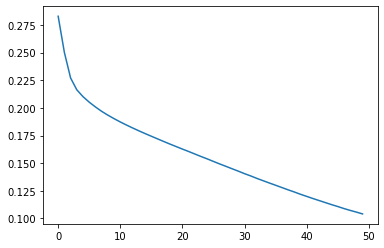

In [49]:
pl.plot(history.history['loss'])

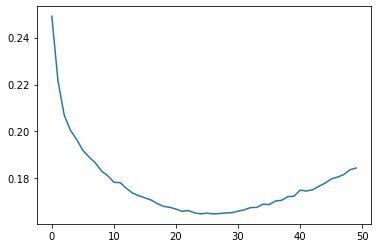

In [50]:
pl.plot(history.history['val_loss'])